这里把只有时一的点位置的假设改成初始末端的位置都不知道来进行推断。为了避免混淆另开一个文件

In [1]:
import bayestorch as bt
from bayestorch import Parameter,Data,Variable,optimizing,vb,sampling,reset
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [2]:
from bayestorch.data.battle import friend_point,enemy_point,battle_point

In [3]:
friend_point1 = friend_point
friend_point0 = friend_point - np.array([0.25,0.25]) + (np.random.random(size=friend_point.shape)-0.5)

In [4]:
timestamp = np.random.random(len(battle_point))

In [5]:
battle_point_time = np.c_[battle_point + np.c_[timestamp,timestamp], timestamp]

In [6]:
enemy_point0 = enemy_point
enemy_point1 = enemy_point0 + np.array([0.5,0.5]) + (np.random.random(size=enemy_point0.shape)-0.5)

In [37]:
def plot_move(x,y,dx,dy,head_width=0.1,**kwargs):
    plt.scatter(x, y,alpha=0.5, **kwargs)
    plt.scatter(x+dx, y+dy, alpha=1.0, **kwargs)
    for i in range(x.shape[0]):
        plt.arrow(x[i], y[i], dx[i], dy[i],head_width=head_width)

def plot_path(x,y,x2,y2,**kwargs):
    plot_move(x,y,x2-x,y2-y,**kwargs)

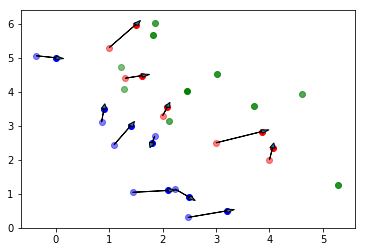

In [8]:
plot_move(friend_point0[:,0], friend_point0[:,1], friend_point1[:,0] - friend_point0[:,0], friend_point1[:,1] - friend_point0[:,1], color='blue')
plot_move(enemy_point0[:,0], enemy_point0[:,1], enemy_point1[:,0] - enemy_point0[:,0], enemy_point1[:,1] - enemy_point0[:,1], color='red')
for i in range(battle_point_time.shape[0]):
    plt.scatter(battle_point_time[i,0],battle_point_time[i,1],color='green',alpha=battle_point_time[i,2]*0.5+0.5)

In [9]:
# transformed data

_logPC = np.log([len(friend_point)/(len(friend_point)+len(enemy_point)),len(enemy_point)/(len(friend_point)+len(enemy_point))])

from bayestorch.distributions import norm_log_prob
from bayestorch.classifier import norm_naive_bayes_predict
from bayestorch.utils import GridSampler2d,cdist,soft_cut_ge,soft_cut_le

model = bt.core.current_model



In [10]:
# model

reset()

friend0 = Data(friend_point0)
friend1 = Data(friend_point1)
enemy0 = Parameter(enemy_point0)
enemy1 = Parameter(enemy_point1)
battle = Data(battle_point[:,:2])
timestamp = Data(battle_point_time[:,2])
logPC = Data(_logPC)

conflict_threshold = 0.2
distance_threshold = 1.0
tense = 10.0
alpha = 5.0
prior_threshold = 5.0
prior_tense = 5.0


In [11]:
def target():
    # 由于每个时点所涉及的mu,sd发生了变化所以不能像之前那样统一的处理，暂时也没看出显然的向量化写法
    target = Variable(torch.zeros(1))
    for i in range(battle_point.shape[0]):
        t = timestamp[i]
        friend = friend0*(1-t) + friend1*t
        enemy = enemy0*(1-t) + enemy1*t
        single_battle = torch.unsqueeze(battle[i],0) # 这个应该会退化为向量，不一定符合结果
        
        friend_enemy = torch.cat((friend, enemy), 0)
        distance = cdist(single_battle, friend_enemy).min(dim=1)[0]
        
        mu = Variable(torch.zeros(2,2)) #目前外层还有个同名的numpy.array mu,sd变量不要搞混了
        sd = Variable(torch.zeros(2,2))

        mu[0,:] = friend.mean(dim=0)
        mu[1,:] = enemy.mean(dim=0)
        sd[0,:] = friend.std(dim=0)
        sd[1,:] = enemy.std(dim=0)

        conflict = torch.exp(norm_naive_bayes_predict(single_battle, mu, sd, logPC)).prod(dim=1)
        p = soft_cut_ge(conflict,conflict_threshold, tense = tense) * soft_cut_le(distance, distance_threshold, tense = tense)

        target+= torch.sum(torch.log(p))
    return target


In [12]:
res = vb(target)
res

(array([1.14536258, 4.97112098, 1.26680893, 4.45453514, 2.25314392,
        3.53327154, 3.53503686, 3.03103795, 4.01648987, 2.32260965,
        1.47131686, 5.74460219, 1.72716149, 4.39816583, 2.38641657,
        3.62675321, 4.0791664 , 2.72383308, 4.11443435, 1.98752199]),
 array([-0.27637444, -0.10587621,  0.0814105 ,  0.11259341,  0.88706157,
         0.58833553,  0.24541471,  0.2543795 ,  0.44564728,  0.8282455 ,
         0.15971052,  0.31048716,  0.56162449,  0.65389653,  0.49470969,
         0.49991817,  0.41792626,  0.73195078,  0.3694674 ,  0.72886738]))

In [14]:
model.vb_meanfield_format(res)[enemy0]

{'mu': array([[1.14536258, 4.97112098],
        [1.26680893, 4.45453514],
        [2.25314392, 3.53327154],
        [3.53503686, 3.03103795],
        [4.01648987, 2.32260965]]), 'omega': array([[-0.27637444, -0.10587621],
        [ 0.0814105 ,  0.11259341],
        [ 0.88706157,  0.58833553],
        [ 0.24541471,  0.2543795 ],
        [ 0.44564728,  0.8282455 ]])}

In [15]:
model.vb_meanfield_format(res)[enemy1]

{'mu': array([[1.47131686, 5.74460219],
        [1.72716149, 4.39816583],
        [2.38641657, 3.62675321],
        [4.0791664 , 2.72383308],
        [4.11443435, 1.98752199]]), 'omega': array([[0.15971052, 0.31048716],
        [0.56162449, 0.65389653],
        [0.49470969, 0.49991817],
        [0.41792626, 0.73195078],
        [0.3694674 , 0.72886738]])}

In [ ]:
def display_data():
    '''
    plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
    plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
    plt.scatter(battle_point[:,0],battle_point[:,1],color='green',label='battle')
    plt.legend()
    '''
    
    plot_move(friend_point0[:,0], friend_point0[:,1], friend_point1[:,0] - friend_point0[:,0], friend_point1[:,1] - friend_point0[:,1], color='blue')
    plot_move(enemy_point0[:,0], enemy_point0[:,1], enemy_point1[:,0] - enemy_point0[:,0], enemy_point1[:,1] - enemy_point0[:,1], color='red')
    for i in range(battle_point_time.shape[0]):
        plt.scatter(battle_point_time[i,0],battle_point_time[i,1],color='green',alpha=battle_point_time[i,2]*0.5+0.5)


def show_change(enemy_point,enemy,show=False):
    display_data()
    for i in range(enemy_point.shape[0]):
        #s = 0.1
        plt.arrow(enemy_point[i][0], enemy_point[i][1], enemy.data[i][0] - enemy_point[i][0], enemy.data[i][1] - enemy_point[i][1],head_width=0.1)
    plt.legend()
    if show:
        plt.show()


def show_ellipse(enemy_point,enemy,mu,sd):
    from matplotlib.patches import Ellipse
    
    #ax = plt.subplot(111)
    ax = plt.gca() # get current axe, the lame method to support command style
    show_change(enemy_point,enemy,show=False)
    #res_reshaped = [r.reshape(enemy_point.shape) for r in res]
    for i in range(enemy_point.shape[0]):
        mu_x,mu_y = mu[i]
        sd_x,sd_y = sd[i]
        e=Ellipse((mu_x,mu_y), sd_x, sd_y, 0)
        e.set_clip_box(ax.bbox)
        e.set_alpha(0.1)
        ax.add_artist(e)
        
    #plt.show()
    
    
def show_vb(vb_res):
    res = vb_res
    model.set_parameter(res[0])
    res_reshaped = [r.reshape(enemy_point.shape) for r in res]
    mu = res_reshaped[0]
    sd = np.exp(res_reshaped[1])
    show_ellipse(enemy_point,enemy,mu,sd)

In [40]:


def show_ellipse(mu,sd,color=None,alpha=0.1):
    from matplotlib.patches import Ellipse
    
    #ax = plt.subplot(111)
    ax = plt.gca() # get current axe, the lame method to support command style
    #show_change(enemy_point,enemy,show=False)
    #res_reshaped = [r.reshape(enemy_point.shape) for r in res]
    for i in range(mu.shape[0]):
        mu_x,mu_y = mu[i]
        sd_x,sd_y = sd[i]
        e=Ellipse((mu_x,mu_y), sd_x, sd_y, 0)
        e.set_clip_box(ax.bbox)
        e.set_alpha(alpha)
        e.set_facecolor(color=color)
        ax.add_artist(e)

def show_vb(vb_res):
    est = model.vb_meanfield_format(vb_res)
    plot_path(est[enemy0]['mu'][:,0], est[enemy0]['mu'][:,1], est[enemy1]['mu'][:,0], est[enemy1]['mu'][:,1],color='red')
    plot_path(enemy_point0[:,0], enemy_point0[:,1], est[enemy0]['mu'][:,0], est[enemy0]['mu'][:,1],color='red')
    show_ellipse(est[enemy0]['mu'], np.exp(est[enemy0]['omega']),alpha=0.1)
    show_ellipse(est[enemy1]['mu'], np.exp(est[enemy1]['omega']),alpha=0.3)

In [41]:
def show_true(show_enemy=True,head_width = 0.1):
    plot_move(friend_point0[:,0], friend_point0[:,1], friend_point1[:,0] - friend_point0[:,0], friend_point1[:,1] - friend_point0[:,1], 
              color='blue', head_width = head_width)
    if show_enemy:
        plot_move(enemy_point0[:,0], enemy_point0[:,1], enemy_point1[:,0] - enemy_point0[:,0], enemy_point1[:,1] - enemy_point0[:,1], 
                  color='red', head_width = head_width)
    for i in range(battle_point_time.shape[0]):
        plt.scatter(battle_point_time[i,0],battle_point_time[i,1],color='green',alpha=battle_point_time[i,2]*0.5+0.5)

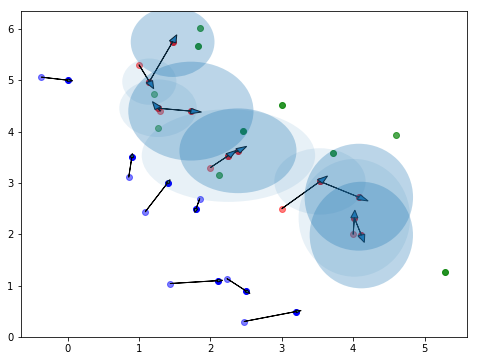

In [44]:
plt.figure(figsize=(8,6))
show_true(show_enemy=False, head_width=0.05)
show_vb(res)
plt.show()

In [28]:
    from matplotlib.patches import Ellipse


In [29]:
Ellipse.set_facecolor?